Types of classification problems:
1. binary - 1 of 2 categories (yes or no)
2. multi-class - 1 of n categories (fish, chicken, or steak)
3. multi-label - n of m categories (tags)
Components:
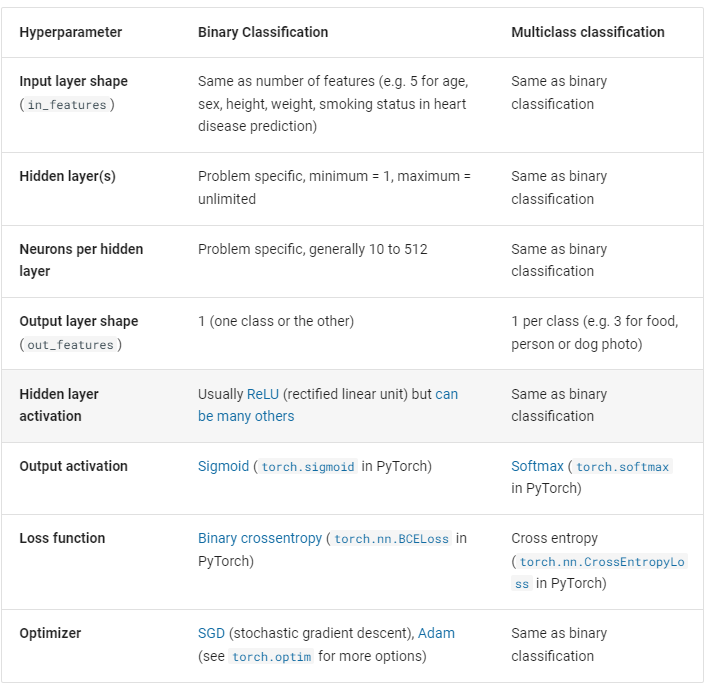[link text](https://)

In [ ]:
from sklearn.datasets import make_circles
import pandas as pd
n_samples = 1000

X,y = make_circles(n_samples,
                   noise = .03,
                   random_state = 42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

#standard to work with dataframes of each circle
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

circles.head()

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
circles.label.value_counts()#how many of each labela re in the dataset

1    500
0    500
Name: label, dtype: int64

((1000, 2), (1000,))

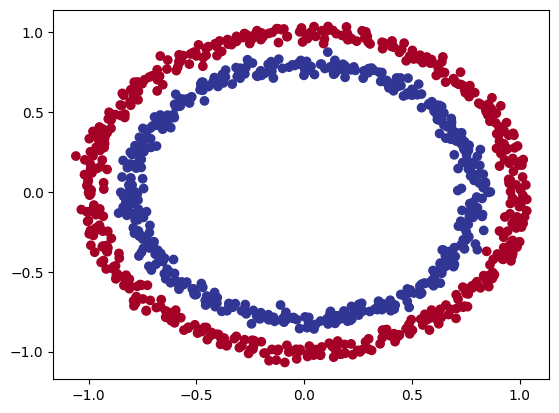

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

X.shape, y.shape

In [ ]:
import torch
#now we have the data as tensors which makes them easier to work
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#now lets split the data a bit more efficiently using

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state = 42)


len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [ ]:
from torch import nn

#device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #create 2 nn.linear layers to hand X,y i/o
        self.layer_1 = nn.Linear(in_features=2, out_features = 5) # takes 2 (X - remember 2d), outputs 5(hidden)
        self.layer_2 = nn.Linear(in_features=5, out_features = 1) #takes 5(hidden), returns 1 (y)
    #define forward method
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) #layer 1 -> layer2

#create instance of the model

model_0 = CircleModelV0().to(device) #5 hidden units = nuerons
#nuerons
#allows the machine to create more hidden values, this usually improves production of output values
# the next step must take the same amount as the prev output,
#and the final value must return the same as the output data

In [ ]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")#

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0925],
        [ 0.2393],
        [-0.2154],
        [ 0.1794],
        [-0.0932],
        [-0.0045],
        [ 0.3120],
        [ 0.2552],
        [-0.2201],
        [ 0.2505]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
# our loss function  -- this is going to be different between models, search for the appropriate one based on the problem you're solving

loss_fn = nn.BCEWithLogitsLoss() #sigmoid built in, might be valuable to seperate later w dif loss function
                                 #relu and sigmoid perform similar functions, usually relu> , but demo?
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=.1) #many optimizers too but SGD is super useful effective across tools, ADAM is too


# we also need an eval metric, similar to loss function, but by creating this you can analyze the efficacy of models from several perspectives

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69641, Accuracy: 51.00% | Test loss: 0.70558, Test acc: 46.00%
Epoch: 100 | Loss: 0.69318, Accuracy: 51.00% | Test loss: 0.69670, Test acc: 46.00%
Epoch: 200 | Loss: 0.69301, Accuracy: 51.12% | Test loss: 0.69532, Test acc: 46.50%
Epoch: 300 | Loss: 0.69299, Accuracy: 51.62% | Test loss: 0.69495, Test acc: 46.50%
Epoch: 400 | Loss: 0.69298, Accuracy: 50.88% | Test loss: 0.69481, Test acc: 46.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69475, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69472, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69470, Test acc: 44.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69469, Test acc: 45.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69469, Test acc: 45.00%


In [ ]:
import requests
from pathlib import Path
#super useful little tool kit to help visualize information/other support tools


# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists, skipping download


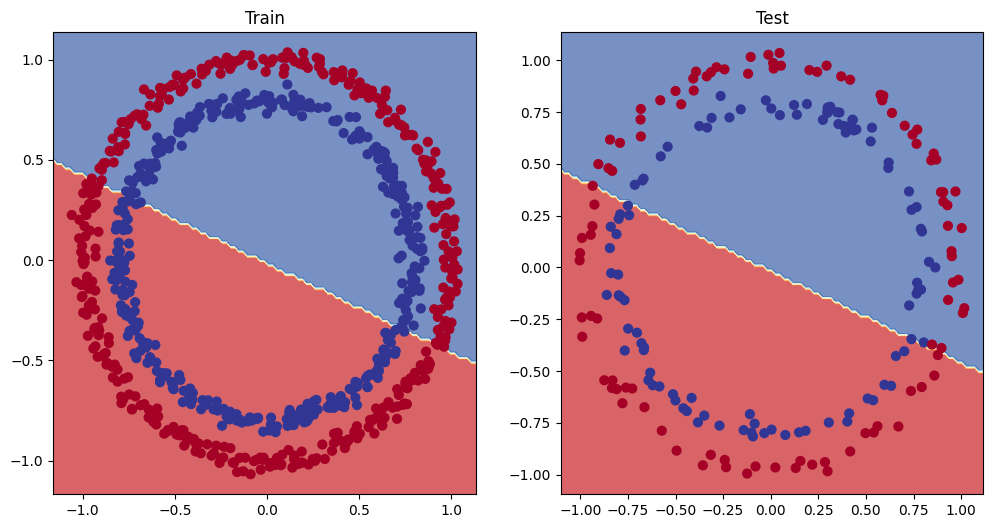

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
#clearly this isn't working so how do we make it better?
'''
1. add more layers
2. add more hidden values
3. keep running it  (more epochs)
4. change the activation functions (linear vs non linear vs etc)
5. change the learning rate ( maybe it moves too much maybe not enough )
6. change the loss funciton/optimizer - are you using the right tool for the job
7. learning transfer (covered later)
'''

'\n1. add more layers \n2. add more hidden values\n3. keep running it  (more epochs)\n4. change the activation functions (linear vs non linear vs etc)\n5. change the learning rate ( maybe it moves too much maybe not enough )\n6. change the loss funciton/optimizer - are you using the right tool for the job \n7. learning transfer (covered later)\n'

In [ ]:
#now we build a model that doesn't have to be linear bc the data isn't (general use case)


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()
    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)  #don't mind the numbering, the text book did shenanigans I skipped


# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)


In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

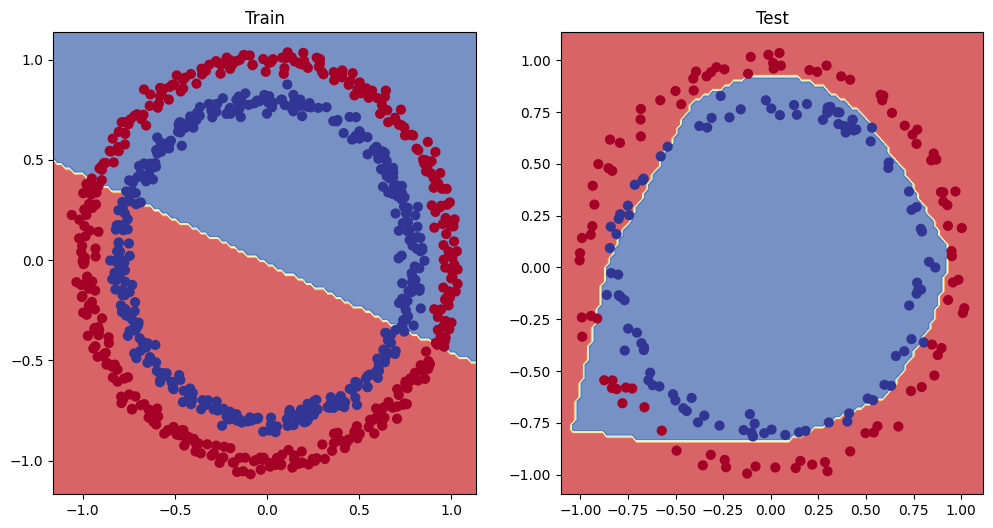

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_0 = linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

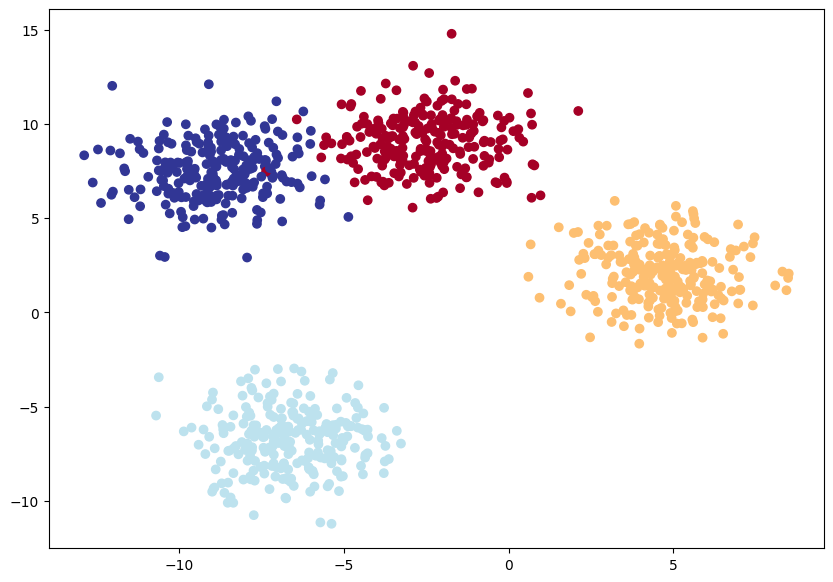

In [ ]:
#now lets build a multi class identified

import torch
from torch import nn
import matplotlib.pyplot as plt
from  sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#super simple, 2 bit classification of objects
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES, # amount of features
                            centers = NUM_CLASSES,  # amnount of labels
                            cluster_std = 1.5,  #data clusters to make things harder
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).to(torch.long)


X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=.2,
                                                                        random_state= RANDOM_SEED)


plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c = y_blob, cmap =plt.cm.RdYlBu)


In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features,output_features, hidden_units = 8): # note - you need to innitialize innitial values of the model
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features,out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,out_features = hidden_units),
            nn.Linear(in_features = hidden_units,out_features = output_features),
        )
    def forward(self,x):
        return self.layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

In [ ]:
#loss & optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=.1)

y_logits = model_4(X_blob_train.to(device)) # single innitial forward pass  to start it up

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.18218, Acc: 29.50% | Test Loss: 0.92226, Test Acc: 70.00%
Epoch: 10 | Loss: 0.48415, Acc: 96.75% | Test Loss: 0.48694, Test Acc: 97.50%
Epoch: 20 | Loss: 0.33571, Acc: 99.00% | Test Loss: 0.34120, Test Acc: 99.50%
Epoch: 30 | Loss: 0.25764, Acc: 99.00% | Test Loss: 0.25995, Test Acc: 99.50%
Epoch: 40 | Loss: 0.18760, Acc: 99.00% | Test Loss: 0.18233, Test Acc: 99.50%
Epoch: 50 | Loss: 0.10798, Acc: 99.00% | Test Loss: 0.09815, Test Acc: 99.50%
Epoch: 60 | Loss: 0.06487, Acc: 99.12% | Test Loss: 0.05628, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04906, Acc: 99.25% | Test Loss: 0.04078, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04183, Acc: 99.12% | Test Loss: 0.03347, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03775, Acc: 99.12% | Test Loss: 0.02922, Test Acc: 99.50%


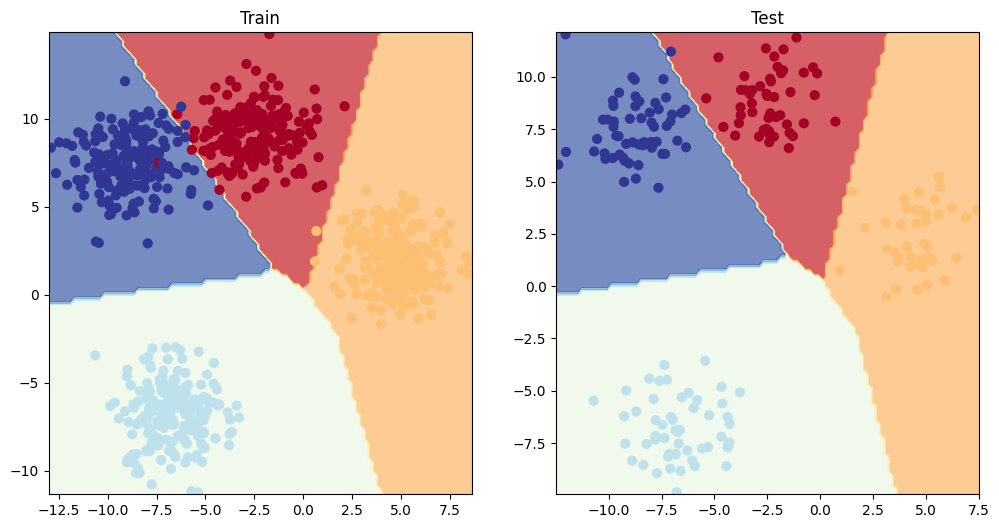

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)